In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
from scipy.fft import fft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# โหลดข้อมูล
df = pd.read_csv('./data/dynamic_record_gesture.csv')

print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"\nDataset shape: {df.shape}")
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")

print("\nColumn names:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe())

print("\nGesture distribution:")
print(df['gesture_name'].value_counts())

print("\nUnique sessions (IDs):")
print(f"Total sessions: {df['id'].nunique()}")
print(df['id'].value_counts().head(10))

# กำหนด sensor columns
sensor_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'p0', 'p1', 'p2', 'p3']

DATASET OVERVIEW

Dataset shape: (2361, 13)
Total rows: 2361
Total columns: 13

Column names:
['id', 'gesture_name', 'timestamp', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'p0', 'p1', 'p2', 'p3']

First 5 rows:
   id gesture_name  timestamp    ax    ay    az    gx    gy    gz    p0    p1  \
0   1         idle    1066413  0.01 -0.04  0.82 -0.42  0.41  0.16  4095  4095   
1   1         idle    1066425  0.02 -0.05  0.82  0.12  0.39  0.06  4095  4095   
2   1         idle    1066437  0.03 -0.03  0.81 -0.25  0.17 -0.25  4095  4095   
3   1         idle    1066449  0.04 -0.02  0.84  0.15  0.36  0.12  4095  4095   
4   1         idle    1066461  0.03 -0.02  0.83  0.25  0.10 -0.25  4095  4095   

     p2    p3  
0  4095  4095  
1  4095  4095  
2  4095  4095  
3  4095  4095  
4  4095  4095  

Data types:
id                int64
gesture_name        str
timestamp         int64
ax              float64
ay              float64
az              float64
gx              float64
gy              float64
gz     

In [3]:
# Data Cleaning and Preprocessing

print("\n" + "="*50)
print("DATA QUALITY CHECK")
print("="*50)

# 1. ตรวจสอบ Missing Values
print("\n1. Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print("Columns with missing values:")
    print(missing[missing > 0])
    print(f"\nTotal missing: {missing.sum()}")
else:
    print("✓ No missing values found")

# 2. ตรวจสอบ Duplicate Rows
print("\n2. Duplicate Rows:")
duplicates = df.duplicated().sum()
print(f"Total duplicates: {duplicates}")
if duplicates > 0:
    print("Sample duplicates:")
    print(df[df.duplicated()].head())

# 3. ตรวจสอบ Data Types
print("\n3. Data Type Check:")
expected_types = {
    'id': ['int64', 'int32'],
    'gesture_name': ['object'],
    'timestamp': ['int64', 'int32', 'float64'],
}
for col in sensor_cols:
    expected_types[col] = ['float64', 'int64']

for col in df.columns:
    if col in expected_types:
        if str(df[col].dtype) not in expected_types[col]:
            print(f"⚠ {col}: {df[col].dtype} (expected {expected_types[col]})")
        else:
            print(f"✓ {col}: {df[col].dtype}")

# 4. ตรวจสอบ Outliers ใน Sensor Data
print("\n4. Sensor Data Range Check:")
print("\nAccelerometer (expected: -2g to +2g ≈ -20 to +20 m/s²):")
for col in ['ax', 'ay', 'az']:
    print(f"  {col}: min={df[col].min():.4f}, max={df[col].max():.4f}")

print("\nGyroscope (expected: -250 to +250 deg/s or similar):")
for col in ['gx', 'gy', 'gz']:
    print(f"  {col}: min={df[col].min():.4f}, max={df[col].max():.4f}")

print("\nPressure sensors:")
for col in ['p0', 'p1', 'p2', 'p3']:
    print(f"  {col}: min={df[col].min():.4f}, max={df[col].max():.4f}")

# 5. ตรวจสอบ Timestamp Consistency
print("\n5. Timestamp Analysis:")
df_sorted = df.sort_values(['id', 'timestamp'])
df_sorted['time_diff'] = df_sorted.groupby('id')['timestamp'].diff()

print(f"Mean sampling interval: {df_sorted['time_diff'].mean():.2f} ms")
print(f"Median sampling interval: {df_sorted['time_diff'].median():.2f} ms")
print(f"Std sampling interval: {df_sorted['time_diff'].std():.2f} ms")

# หา sampling rate ประมาณ
if df_sorted['time_diff'].median() > 0:
    sampling_rate = 1000 / df_sorted['time_diff'].median()
    print(f"Estimated sampling rate: {sampling_rate:.2f} Hz")

# 6. ตรวจสอบ Sessions
print("\n6. Session Analysis:")
session_lengths = df.groupby('id').size()
print(f"Average samples per session: {session_lengths.mean():.0f}")
print(f"Min samples per session: {session_lengths.min()}")
print(f"Max samples per session: {session_lengths.max()}")

# Sessions ที่สั้นเกินไป
min_required_samples = 100  # ต้องมีอย่างน้อย 100 samples
short_sessions = session_lengths[session_lengths < min_required_samples]
if len(short_sessions) > 0:
    print(f"\n⚠ Sessions with < {min_required_samples} samples: {len(short_sessions)}")
    print(short_sessions)


DATA QUALITY CHECK

1. Missing Values:
✓ No missing values found

2. Duplicate Rows:
Total duplicates: 0

3. Data Type Check:
✓ id: int64
⚠ gesture_name: str (expected ['object'])
✓ timestamp: int64
✓ ax: float64
✓ ay: float64
✓ az: float64
✓ gx: float64
✓ gy: float64
✓ gz: float64
✓ p0: int64
✓ p1: int64
✓ p2: int64
✓ p3: int64

4. Sensor Data Range Check:

Accelerometer (expected: -2g to +2g ≈ -20 to +20 m/s²):
  ax: min=-0.2000, max=1.3400
  ay: min=-0.1200, max=0.5500
  az: min=0.0700, max=1.2500

Gyroscope (expected: -250 to +250 deg/s or similar):
  gx: min=-42.1100, max=31.8400
  gy: min=-46.2200, max=35.4000
  gz: min=-15.7900, max=33.8400

Pressure sensors:
  p0: min=3627.0000, max=4095.0000
  p1: min=3223.0000, max=4095.0000
  p2: min=3686.0000, max=4095.0000
  p3: min=3662.0000, max=4095.0000

5. Timestamp Analysis:
Mean sampling interval: 983.53 ms
Median sampling interval: 12.00 ms
Std sampling interval: 17109.92 ms
Estimated sampling rate: 83.33 Hz

6. Session Analysis:



DATA VISUALIZATION

✓ Saved: ./data/output/data_distribution.png


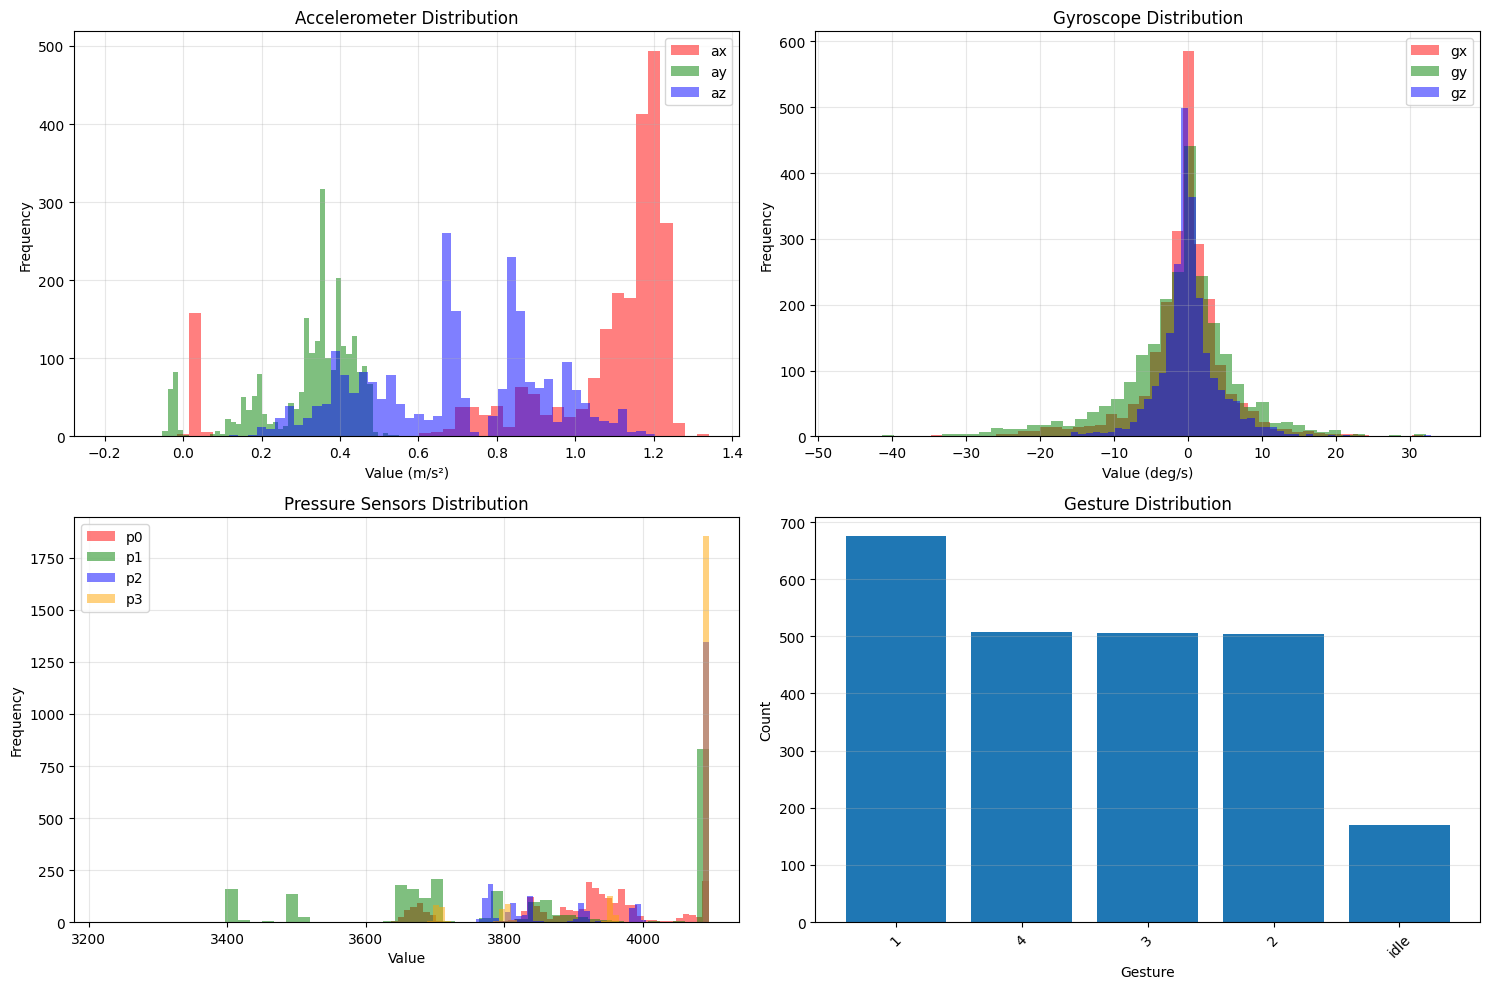


2. Plotting sample time series...
✓ Saved: ./data/output/sample_timeseries.png


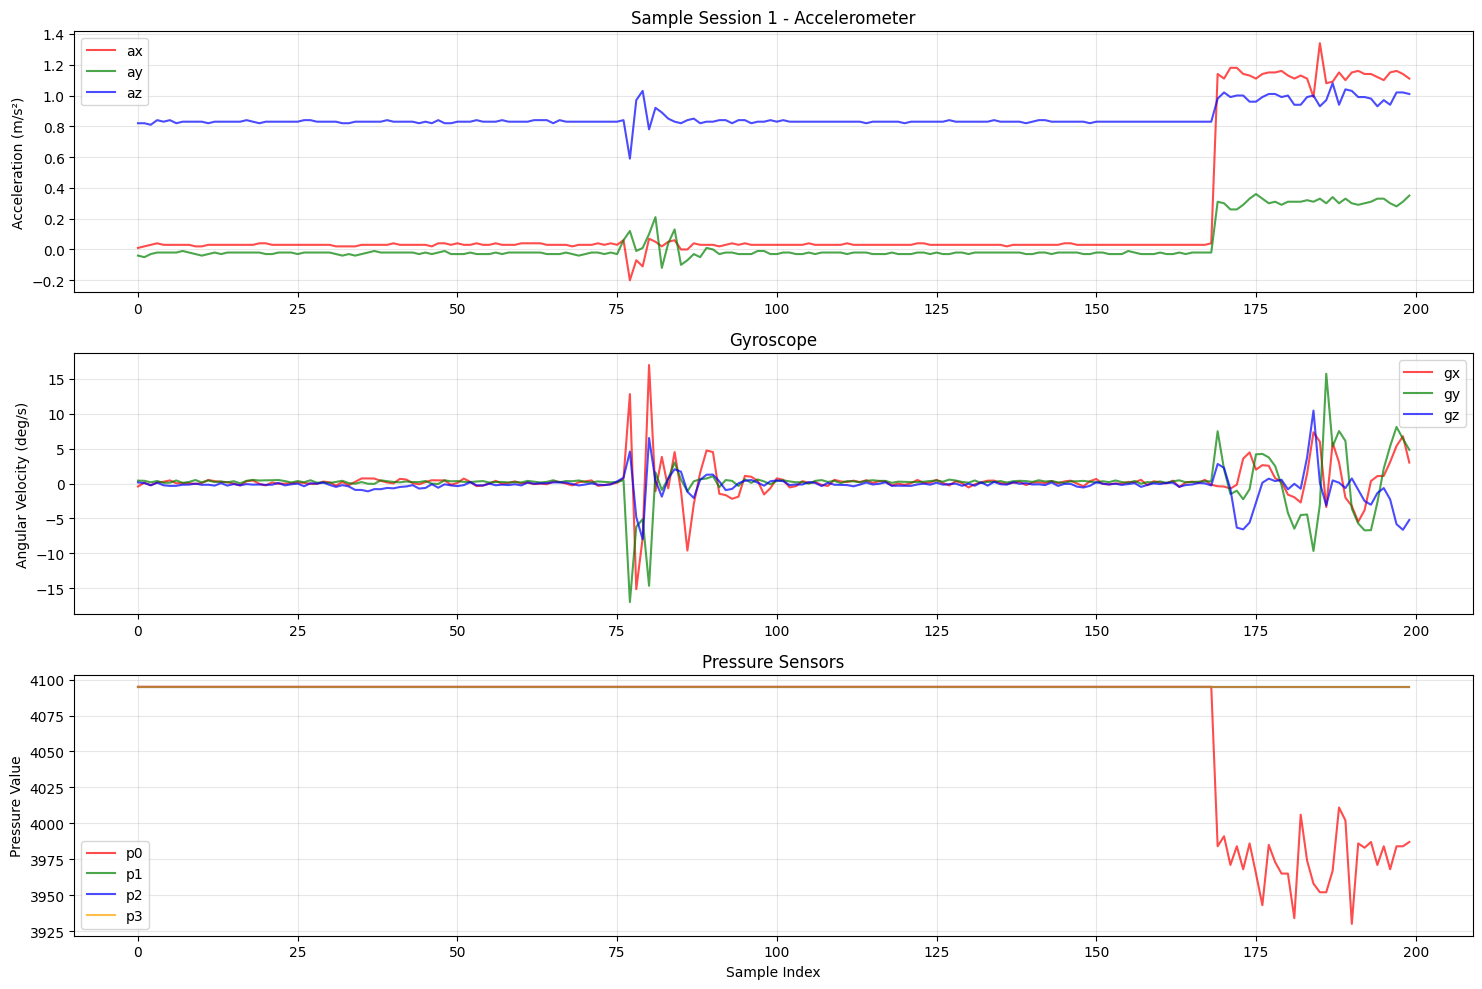


✓ Data visualization completed


In [5]:
# Visualization

print("\n" + "="*50)
print("DATA VISUALIZATION")
print("="*50)

# 1. Sensor Data Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accelerometer
for col, color in zip(['ax', 'ay', 'az'], ['red', 'green', 'blue']):
    axes[0, 0].hist(df[col], bins=50, alpha=0.5, label=col, color=color)
axes[0, 0].set_xlabel('Value (m/s²)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Accelerometer Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gyroscope
for col, color in zip(['gx', 'gy', 'gz'], ['red', 'green', 'blue']):
    axes[0, 1].hist(df[col], bins=50, alpha=0.5, label=col, color=color)
axes[0, 1].set_xlabel('Value (deg/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Gyroscope Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Pressure
for col, color in zip(['p0', 'p1', 'p2', 'p3'], ['red', 'green', 'blue', 'orange']):
    axes[1, 0].hist(df[col], bins=50, alpha=0.5, label=col, color=color)
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Pressure Sensors Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gesture distribution
gesture_counts = df['gesture_name'].value_counts()
axes[1, 1].bar(range(len(gesture_counts)), gesture_counts.values)
axes[1, 1].set_xticks(range(len(gesture_counts)))
axes[1, 1].set_xticklabels(gesture_counts.index, rotation=45)
axes[1, 1].set_xlabel('Gesture')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Gesture Distribution')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./data/output/data_distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: ./data/output/data_distribution.png")
plt.show()

# 2. Sample Time Series
print("\n2. Plotting sample time series...")
sample_session = df['id'].iloc[0]
sample_data = df[df['id'] == sample_session].iloc[:200]  # แสดง 200 samples แรก

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Accelerometer
axes[0].plot(sample_data['ax'], label='ax', color='red', alpha=0.7)
axes[0].plot(sample_data['ay'], label='ay', color='green', alpha=0.7)
axes[0].plot(sample_data['az'], label='az', color='blue', alpha=0.7)
axes[0].set_ylabel('Acceleration (m/s²)')
axes[0].set_title(f'Sample Session {sample_session} - Accelerometer')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gyroscope
axes[1].plot(sample_data['gx'], label='gx', color='red', alpha=0.7)
axes[1].plot(sample_data['gy'], label='gy', color='green', alpha=0.7)
axes[1].plot(sample_data['gz'], label='gz', color='blue', alpha=0.7)
axes[1].set_ylabel('Angular Velocity (deg/s)')
axes[1].set_title('Gyroscope')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Pressure
axes[2].plot(sample_data['p0'], label='p0', color='red', alpha=0.7)
axes[2].plot(sample_data['p1'], label='p1', color='green', alpha=0.7)
axes[2].plot(sample_data['p2'], label='p2', color='blue', alpha=0.7)
axes[2].plot(sample_data['p3'], label='p3', color='orange', alpha=0.7)
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Pressure Value')
axes[2].set_title('Pressure Sensors')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data/output/sample_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ./data/output/sample_timeseries.png")
plt.show()

print("\n✓ Data visualization completed")


LABEL/TARGET VERIFICATION

All unique gestures in dataset:
<StringArray>
['idle', '1', '2', '3', '4']
Length: 5, dtype: str

Expected gestures: ['idle', '1', '2', '3', '4']

✓ All expected gestures are present
✓ No unexpected gestures found

Gesture distribution:
gesture_name
1       675
4       507
3       506
2       504
idle    169
Name: count, dtype: int64

Gesture proportions:
  1: 28.59%
  4: 21.47%
  3: 21.43%
  2: 21.35%
  idle: 7.16%

Class imbalance ratio: 3.99
⚠ Warning: Significant class imbalance detected!
  Consider using stratified sampling or class weights

✓ Saved: ./data/output/gesture_distribution.png


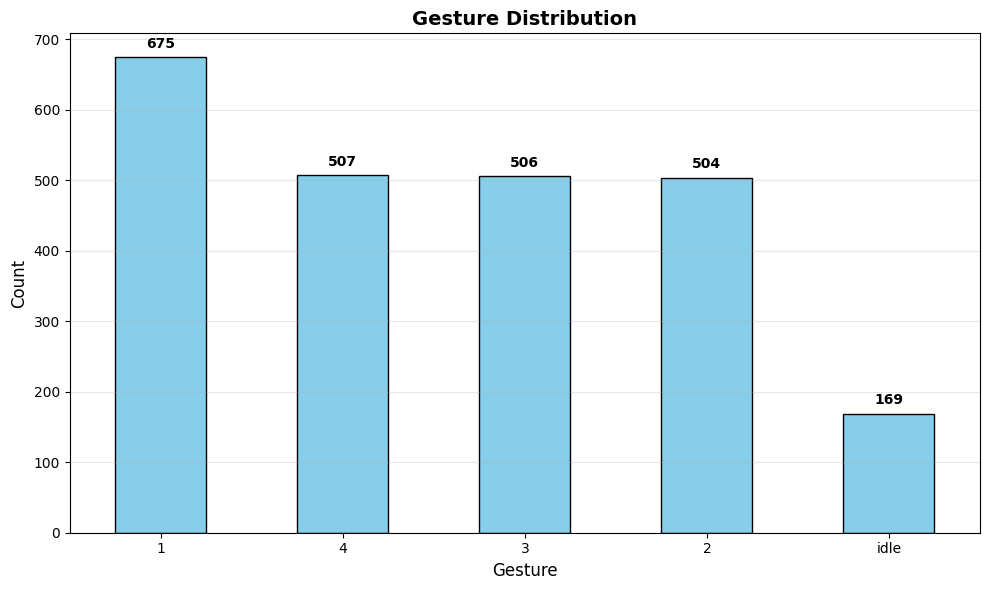

In [6]:
print("\n" + "="*50)
print("LABEL/TARGET VERIFICATION")
print("="*50)

# ตรวจสอบ labels ทั้งหมด
print("\nAll unique gestures in dataset:")
all_gestures = df['gesture_name'].unique()
print(all_gestures)

# Expected gestures
expected_gestures = ['idle', '1', '2', '3', '4']
print(f"\nExpected gestures: {expected_gestures}")

# ตรวจสอบว่าครบไหม
missing_gestures = set(expected_gestures) - set(all_gestures)
extra_gestures = set(all_gestures) - set(expected_gestures)

if missing_gestures:
    print(f"\n⚠ Missing gestures: {missing_gestures}")
else:
    print("\n✓ All expected gestures are present")

if extra_gestures:
    print(f"⚠ Extra/Unexpected gestures: {extra_gestures}")
else:
    print("✓ No unexpected gestures found")

# นับจำนวนแต่ละ gesture
print("\nGesture distribution:")
gesture_counts = df['gesture_name'].value_counts()
print(gesture_counts)

# สัดส่วน
print("\nGesture proportions:")
gesture_props = df['gesture_name'].value_counts(normalize=True) * 100
for gesture, prop in gesture_props.items():
    print(f"  {gesture}: {prop:.2f}%")

# ตรวจสอบ class imbalance
max_count = gesture_counts.max()
min_count = gesture_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠ Warning: Significant class imbalance detected!")
    print("  Consider using stratified sampling or class weights")
else:
    print("✓ Classes are reasonably balanced")

# Visualization
plt.figure(figsize=(10, 6))
gesture_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Gesture Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Gesture', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

# เพิ่มค่าบน bar
for i, v in enumerate(gesture_counts.values):
    plt.text(i, v + max_count*0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('./data/output/gesture_distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: ./data/output/gesture_distribution.png")
plt.show()


STEP 1: SLICING WINDOWS
Window size: 41 samples
Step size: 20 samples
Overlap: 51%

✓ Windowing completed!
Total windows created: 112
Window shape: (112, 41, 10)
  - Samples per window: 41
  - Features per sample: 10

Window label distribution:
1       33
3       26
2       25
4       19
idle     9
Name: count, dtype: int64

Window label proportions:
  1: 33 windows (29.46%)
  3: 26 windows (23.21%)
  2: 25 windows (22.32%)
  4: 19 windows (16.96%)
  idle: 9 windows (8.04%)



✓ Saved: ./data/output/windowing_results.png


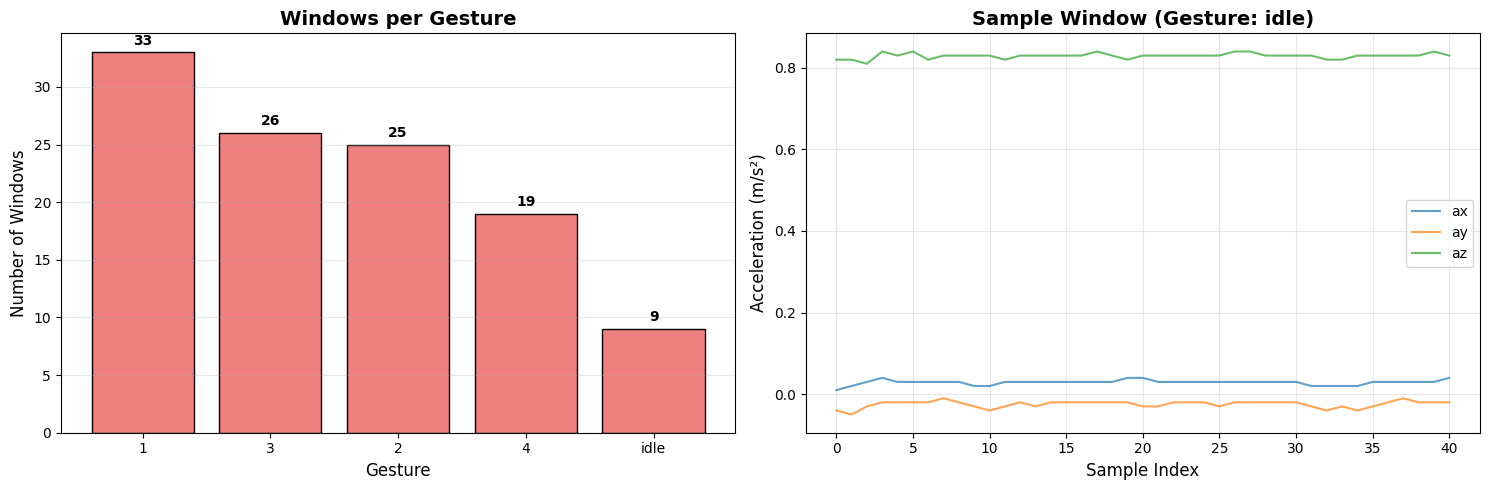

In [28]:
#slicing window

print("\n" + "="*50)
print("STEP 1: SLICING WINDOWS")
print("="*50)

# Parameters
window_size = 41   # จำนวน samples ต่อ window (~1.2 วินาที ที่ 83Hz)
step_size = 20      # overlap 50%

print(f"Window size: {window_size} samples")
print(f"Step size: {step_size} samples")
print(f"Overlap: {((window_size - step_size) / window_size * 100):.0f}%")

# สร้าง windows
X_windows = []
y_labels = []
window_info = []  # เก็บข้อมูลเพิ่มเติมเกี่ยวกับแต่ละ window

for session_id in df['id'].unique():
    temp = df[df['id'] == session_id].reset_index(drop=True)
    
    data = temp[sensor_cols].values
    labels = temp['gesture_name'].values
    
    # นับจำนวน windows ที่จะได้จาก session นี้
    n_windows = 0
    
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i+window_size]
        label = labels[i]  # ใช้ label แรกของ window
        
        X_windows.append(window)
        y_labels.append(label)
        window_info.append({
            'session_id': session_id,
            'start_idx': i,
            'end_idx': i + window_size,
            'gesture': label
        })
        n_windows += 1

X_windows = np.array(X_windows)
y_labels = np.array(y_labels)

print(f"\n✓ Windowing completed!")
print(f"Total windows created: {len(X_windows)}")
print(f"Window shape: {X_windows.shape}")
print(f"  - Samples per window: {X_windows.shape[1]}")
print(f"  - Features per sample: {X_windows.shape[2]}")

# ตรวจสอบการกระจายของ labels ใน windows
print("\nWindow label distribution:")
window_label_counts = pd.Series(y_labels).value_counts()
print(window_label_counts)

print("\nWindow label proportions:")
for label, count in window_label_counts.items():
    prop = count / len(y_labels) * 100
    print(f"  {label}: {count} windows ({prop:.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Window distribution by gesture
axes[0].bar(range(len(window_label_counts)), window_label_counts.values, 
            color='lightcoral', edgecolor='black')
axes[0].set_xticks(range(len(window_label_counts)))
axes[0].set_xticklabels(window_label_counts.index)
axes[0].set_xlabel('Gesture', fontsize=12)
axes[0].set_ylabel('Number of Windows', fontsize=12)
axes[0].set_title('Windows per Gesture', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(window_label_counts.values):
    axes[0].text(i, v + max(window_label_counts.values)*0.02, str(v), 
                ha='center', fontweight='bold')

# Sample window visualization
sample_idx = 0
sample_window = X_windows[sample_idx]
sample_label = y_labels[sample_idx]

axes[1].plot(sample_window[:, 0], label='ax', alpha=0.7)
axes[1].plot(sample_window[:, 1], label='ay', alpha=0.7)
axes[1].plot(sample_window[:, 2], label='az', alpha=0.7)
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Acceleration (m/s²)', fontsize=12)
axes[1].set_title(f'Sample Window (Gesture: {sample_label})', 
                 fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data/output/windowing_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: ./data/output/windowing_results.png")
plt.show()

In [29]:
# Feature Extraction Functions

print("\n" + "="*50)
print("STEP 2: FEATURE EXTRACTION SETUP")
print("="*50)

def extract_statistical_features(window_data, sensor_names):
    """Statistical features: mean, std, min, max, range, median"""
    features = {}
    
    for i, sensor in enumerate(sensor_names):
        data = window_data[:, i]
        
        features[f'{sensor}_mean'] = np.mean(data)
        features[f'{sensor}_std'] = np.std(data)
        features[f'{sensor}_min'] = np.min(data)
        features[f'{sensor}_max'] = np.max(data)
        features[f'{sensor}_range'] = np.max(data) - np.min(data)
        features[f'{sensor}_median'] = np.median(data)
    
    return features


def extract_time_domain_features(window_data, sensor_names):
    """Time domain: RMS, energy, zero-crossing, skewness, kurtosis"""
    features = {}
    
    for i, sensor in enumerate(sensor_names):
        data = window_data[:, i]
        
        # RMS
        features[f'{sensor}_rms'] = np.sqrt(np.mean(data**2))
        
        # Energy
        features[f'{sensor}_energy'] = np.sum(data**2) / len(data)
        
        # Zero Crossing Rate
        features[f'{sensor}_zcr'] = np.sum(np.diff(np.sign(data)) != 0) / len(data)
        
        # Skewness & Kurtosis (ป้องกัน constant values)
        if np.std(data) > 1e-10:
            features[f'{sensor}_skew'] = stats.skew(data)
            features[f'{sensor}_kurtosis'] = stats.kurtosis(data)
        else:
            features[f'{sensor}_skew'] = 0.0
            features[f'{sensor}_kurtosis'] = 0.0
    
    return features


def extract_frequency_features(window_data, sensor_names):
    """Frequency domain features (FFT) - เฉพาะ IMU sensors"""
    features = {}
    
    # ใช้เฉพาะ accelerometer และ gyroscope (6 sensors แรก)
    imu_sensors = sensor_names[:6]
    
    for i, sensor in enumerate(imu_sensors):
        data = window_data[:, i]
        
        # FFT
        fft_vals = np.abs(fft(data))
        fft_vals = fft_vals[:len(fft_vals)//2]
        
        if len(fft_vals) > 0:
            features[f'{sensor}_fft_mean'] = np.mean(fft_vals)
            features[f'{sensor}_fft_std'] = np.std(fft_vals)
            features[f'{sensor}_fft_max'] = np.max(fft_vals)
            features[f'{sensor}_dominant_freq_idx'] = np.argmax(fft_vals)
        else:
            features[f'{sensor}_fft_mean'] = 0.0
            features[f'{sensor}_fft_std'] = 0.0
            features[f'{sensor}_fft_max'] = 0.0
            features[f'{sensor}_dominant_freq_idx'] = 0.0
    
    return features


def extract_cross_axis_features(window_data):
    """Cross-axis features: magnitude, jerk, correlations"""
    features = {}
    
    # Acceleration magnitude
    acc_mag = np.sqrt(
        window_data[:, 0]**2 + 
        window_data[:, 1]**2 + 
        window_data[:, 2]**2
    )
    features['acc_magnitude_mean'] = np.mean(acc_mag)
    features['acc_magnitude_std'] = np.std(acc_mag)
    features['acc_magnitude_max'] = np.max(acc_mag)
    features['acc_magnitude_min'] = np.min(acc_mag)
    
    # Gyroscope magnitude
    gyro_mag = np.sqrt(
        window_data[:, 3]**2 + 
        window_data[:, 4]**2 + 
        window_data[:, 5]**2
    )
    features['gyro_magnitude_mean'] = np.mean(gyro_mag)
    features['gyro_magnitude_std'] = np.std(gyro_mag)
    features['gyro_magnitude_max'] = np.max(gyro_mag)
    
    # Jerk (rate of change of acceleration)
    if len(window_data) > 1:
        jerk_x = np.diff(window_data[:, 0])
        jerk_y = np.diff(window_data[:, 1])
        jerk_z = np.diff(window_data[:, 2])
        jerk_mag = np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)
        
        features['jerk_mean'] = np.mean(jerk_mag)
        features['jerk_std'] = np.std(jerk_mag)
        features['jerk_max'] = np.max(jerk_mag)
    else:
        features['jerk_mean'] = 0.0
        features['jerk_std'] = 0.0
        features['jerk_max'] = 0.0
    
    # Correlations between axes (ป้องกัน NaN)
    def safe_corr(x, y):
        if np.std(x) < 1e-10 or np.std(y) < 1e-10:
            return 0.0
        corr = np.corrcoef(x, y)[0, 1]
        return 0.0 if np.isnan(corr) else corr
    
    features['corr_ax_ay'] = safe_corr(window_data[:, 0], window_data[:, 1])
    features['corr_ax_az'] = safe_corr(window_data[:, 0], window_data[:, 2])
    features['corr_ay_az'] = safe_corr(window_data[:, 1], window_data[:, 2])
    
    features['corr_gx_gy'] = safe_corr(window_data[:, 3], window_data[:, 4])
    features['corr_gx_gz'] = safe_corr(window_data[:, 3], window_data[:, 5])
    features['corr_gy_gz'] = safe_corr(window_data[:, 4], window_data[:, 5])
    
    return features


def extract_pressure_features(window_data):
    """Pressure sensor specific features"""
    features = {}
    
    # Pressure differences (บอกว่ามีการกดที่ไหน)
    features['p_diff_01'] = np.mean(window_data[:, 6] - window_data[:, 7])
    features['p_diff_02'] = np.mean(window_data[:, 6] - window_data[:, 8])
    features['p_diff_03'] = np.mean(window_data[:, 6] - window_data[:, 9])
    features['p_diff_12'] = np.mean(window_data[:, 7] - window_data[:, 8])
    features['p_diff_23'] = np.mean(window_data[:, 8] - window_data[:, 9])
    
    # Total pressure
    total_pressure = np.sum(window_data[:, 6:10], axis=1)
    features['p_total_mean'] = np.mean(total_pressure)
    features['p_total_std'] = np.std(total_pressure)
    features['p_total_min'] = np.min(total_pressure)
    
    # Active sensors (ที่ไม่ใช่ 4095)
    active_count = np.sum(window_data[:, 6:10] < 4095, axis=1)
    features['p_active_sensors_mean'] = np.mean(active_count)
    features['p_active_sensors_max'] = np.max(active_count)
    
    # Variance across sensors
    features['p_variance_across'] = np.mean(np.var(window_data[:, 6:10], axis=1))
    
    return features


def extract_peak_features(window_data, sensor_names):
    """Peak detection features - เฉพาะ IMU"""
    features = {}
    
    imu_sensors = sensor_names[:6]
    
    for i, sensor in enumerate(imu_sensors):
        data = window_data[:, i]
        
        # Find peaks
        peaks, properties = find_peaks(data, height=0)
        
        features[f'{sensor}_peak_count'] = len(peaks)
        
        if len(peaks) > 1:
            intervals = np.diff(peaks)
            features[f'{sensor}_peak_interval_mean'] = np.mean(intervals)
        else:
            features[f'{sensor}_peak_interval_mean'] = 0.0
    
    return features


def extract_all_features(window_data, sensor_names):
    """รวม features ทั้งหมด"""
    all_features = {}
    
    # 1. Statistical (60 features: 6 stats x 10 sensors)
    all_features.update(extract_statistical_features(window_data, sensor_names))
    
    # 2. Time domain (50 features: 5 stats x 10 sensors)
    all_features.update(extract_time_domain_features(window_data, sensor_names))
    
    # 3. Frequency domain (24 features: 4 stats x 6 IMU sensors)
    all_features.update(extract_frequency_features(window_data, sensor_names))
    
    # 4. Cross-axis (16 features)
    all_features.update(extract_cross_axis_features(window_data))
    
    # 5. Pressure (13 features)
    all_features.update(extract_pressure_features(window_data))
    
    # 6. Peaks (12 features: 2 stats x 6 IMU sensors)
    all_features.update(extract_peak_features(window_data, sensor_names))
    
    return all_features


print("✓ Feature extraction functions defined")
print("\nFeature categories:")
print("  1. Statistical: 60 features")
print("  2. Time domain: 50 features")
print("  3. Frequency domain: 24 features")
print("  4. Cross-axis: 16 features")
print("  5. Pressure: 13 features")
print("  6. Peaks: 12 features")
print("  ─────────────────────────")
print("  Total: ~175 features")


STEP 2: FEATURE EXTRACTION SETUP
✓ Feature extraction functions defined

Feature categories:
  1. Statistical: 60 features
  2. Time domain: 50 features
  3. Frequency domain: 24 features
  4. Cross-axis: 16 features
  5. Pressure: 13 features
  6. Peaks: 12 features
  ─────────────────────────
  Total: ~175 features


In [30]:
# Extract Features จาก Windows
print("\n" + "="*50)
print("STEP 3: EXTRACTING FEATURES FROM WINDOWS")
print("="*50)

# Extract features from all windows
print(f"Processing {len(X_windows)} windows...")
print("This may take a few minutes...\n")

feature_list = []
failed_windows = []

for i, window in enumerate(X_windows):
    if i % 500 == 0 and i > 0:
        print(f"Processed {i}/{len(X_windows)} windows ({i/len(X_windows)*100:.1f}%)")
    
    try:
        features = extract_all_features(window, sensor_cols)
        feature_list.append(features)
    except Exception as e:
        print(f"⚠ Error processing window {i}: {e}")
        failed_windows.append(i)
        # เพิ่ม dummy features
        feature_list.append({})

print(f"\n✓ Feature extraction completed!")
print(f"Total windows processed: {len(X_windows)}")
print(f"Successful: {len(X_windows) - len(failed_windows)}")
if len(failed_windows) > 0:
    print(f"Failed: {len(failed_windows)}")

# Create DataFrame
X_features = pd.DataFrame(feature_list)

print(f"\nFeature matrix shape: {X_features.shape}")
print(f"Total features extracted: {X_features.shape[1]}")

# แสดง feature names แบบจัดกลุ่ม
print("\nSample features by category:")
all_cols = X_features.columns.tolist()

# Statistical
stat_features = [c for c in all_cols if any(x in c for x in ['_mean', '_std', '_min', '_max', '_range', '_median'])]
print(f"\n1. Statistical features ({len(stat_features)}): {stat_features[:5]}...")

# Time domain
time_features = [c for c in all_cols if any(x in c for x in ['_rms', '_energy', '_zcr', '_skew', '_kurtosis'])]
print(f"2. Time domain features ({len(time_features)}): {time_features[:5]}...")

# Frequency
freq_features = [c for c in all_cols if 'fft' in c or 'freq' in c]
print(f"3. Frequency features ({len(freq_features)}): {freq_features[:5]}...")

# Cross-axis
cross_features = [c for c in all_cols if 'magnitude' in c or 'jerk' in c or 'corr' in c]
print(f"4. Cross-axis features ({len(cross_features)}): {cross_features[:5]}...")

# Pressure
pressure_features = [c for c in all_cols if c.startswith('p_')]
print(f"5. Pressure features ({len(pressure_features)}): {pressure_features[:5]}...")

# Peak
peak_features = [c for c in all_cols if 'peak' in c]
print(f"6. Peak features ({len(peak_features)}): {peak_features[:5]}...")


STEP 3: EXTRACTING FEATURES FROM WINDOWS
Processing 112 windows...
This may take a few minutes...


✓ Feature extraction completed!
Total windows processed: 112
Successful: 112

Feature matrix shape: (112, 173)
Total features extracted: 173

Sample features by category:

1. Statistical features (99): ['ax_mean', 'ax_std', 'ax_min', 'ax_max', 'ax_range']...
2. Time domain features (50): ['ax_rms', 'ax_energy', 'ax_zcr', 'ax_skew', 'ax_kurtosis']...
3. Frequency features (24): ['ax_fft_mean', 'ax_fft_std', 'ax_fft_max', 'ax_dominant_freq_idx', 'ay_fft_mean']...
4. Cross-axis features (16): ['acc_magnitude_mean', 'acc_magnitude_std', 'acc_magnitude_max', 'acc_magnitude_min', 'gyro_magnitude_mean']...
5. Pressure features (11): ['p_diff_01', 'p_diff_02', 'p_diff_03', 'p_diff_12', 'p_diff_23']...
6. Peak features (12): ['ax_peak_count', 'ax_peak_interval_mean', 'ay_peak_count', 'ay_peak_interval_mean', 'az_peak_count']...


In [31]:
# Handle Missing Values และ Clean Features

print("\n" + "="*50)
print("STEP 4: CLEANING EXTRACTED FEATURES")
print("="*50)

# 1. Check for NaN
print("1. Checking for NaN values...")
nan_count = X_features.isna().sum().sum()
print(f"   Total NaN values: {nan_count}")

if nan_count > 0:
    print("\n   Columns with NaN:")
    nan_cols = X_features.isna().sum()
    nan_cols = nan_cols[nan_cols > 0].sort_values(ascending=False)
    print(nan_cols.head(10))
    
    # Replace NaN with median
    print("\n   Replacing NaN with median...")
    imputer = SimpleImputer(strategy='median')
    X_features_imputed = pd.DataFrame(
        imputer.fit_transform(X_features),
        columns=X_features.columns
    )
    X_features = X_features_imputed
    print("   ✓ NaN values replaced")
else:
    print("   ✓ No NaN values found")

# 2. Check for Inf
print("\n2. Checking for Inf values...")
inf_count = np.isinf(X_features.values).sum()
print(f"   Total Inf values: {inf_count}")

if inf_count > 0:
    print("   Replacing Inf with median...")
    X_features = X_features.replace([np.inf, -np.inf], np.nan)
    imputer = SimpleImputer(strategy='median')
    X_features = pd.DataFrame(
        imputer.fit_transform(X_features),
        columns=X_features.columns
    )
    print("   ✓ Inf values replaced")
else:
    print("   ✓ No Inf values found")

# 3. Basic statistics
print("\n3. Feature statistics:")
print(f"   Mean range: [{X_features.mean().min():.4f}, {X_features.mean().max():.4f}]")
print(f"   Std range: [{X_features.std().min():.4f}, {X_features.std().max():.4f}]")

# 4. Verify data quality
print("\n4. Final verification:")
print(f"   ✓ Shape: {X_features.shape}")
print(f"   ✓ No NaN: {X_features.isna().sum().sum() == 0}")
print(f"   ✓ No Inf: {np.isinf(X_features.values).sum() == 0}")
print(f"   ✓ All numeric: {X_features.select_dtypes(include=[np.number]).shape[1] == X_features.shape[1]}")

print("\n✓ Feature cleaning completed")


STEP 4: CLEANING EXTRACTED FEATURES
1. Checking for NaN values...
   Total NaN values: 0
   ✓ No NaN values found

2. Checking for Inf values...
   Total Inf values: 0
   ✓ No Inf values found

3. Feature statistics:
   Mean range: [-166.4140, 16343012.6533]
   Std range: [0.0000, 1730416.1835]

4. Final verification:
   ✓ Shape: (112, 173)
   ✓ No NaN: True
   ✓ No Inf: True
   ✓ All numeric: True

✓ Feature cleaning completed



STEP 5: FEATURE SELECTION
Classes: ['1' '2' '3' '4' 'idle']
Encoded labels: [0 1 2 3 4]

1. Removing low variance features...
   Starting features: 173
   Removed: 20 features
   Remaining: 153 features

2. Selecting K-best features using statistical test...
   Selecting top 50 features...
   ✓ Selected 50 features

3. Top 20 selected features:
    1. p_active_sensors_mean                    (score: 813.44)
    2. ax_min                                   (score: 257.26)
    3. p_active_sensors_max                     (score: 234.04)
    4. p1_energy                                (score: 165.38)
    5. ax_mean                                  (score: 165.03)
    6. ax_fft_max                               (score: 165.03)
    7. ax_fft_std                               (score: 159.21)
    8. p1_rms                                   (score: 155.34)
    9. p1_mean                                  (score: 154.28)
   10. p_total_mean                             (score: 133.48)
   11. ax_me

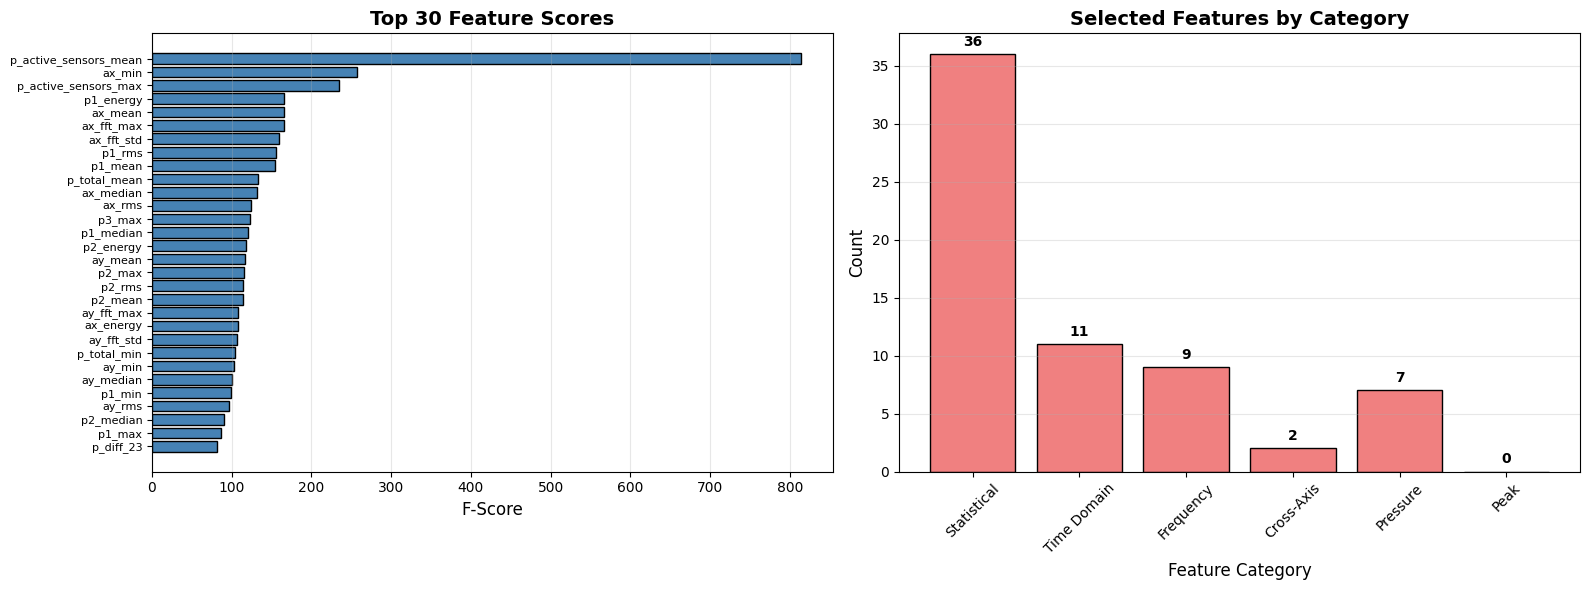


4. Feature selection summary:
   Original features: 173
   After variance threshold: 153
   Final selected features: 50
   Reduction: 71.1%

✓ Feature selection completed


In [32]:
# Feature Selection

print("\n" + "="*50)
print("STEP 5: FEATURE SELECTION")
print("="*50)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

print(f"Classes: {le.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")

# 1. Remove Low Variance Features
print("\n1. Removing low variance features...")
print(f"   Starting features: {X_features.shape[1]}")

selector_var = VarianceThreshold(threshold=0.01)
X_high_var = selector_var.fit_transform(X_features)
high_var_features = X_features.columns[selector_var.get_support()].tolist()

removed_var = X_features.shape[1] - len(high_var_features)
print(f"   Removed: {removed_var} features")
print(f"   Remaining: {len(high_var_features)} features")

X_high_var_df = pd.DataFrame(X_high_var, columns=high_var_features)

# 2. Select K-Best Features
print("\n2. Selecting K-best features using statistical test...")
k_best = min(50, len(high_var_features))
print(f"   Selecting top {k_best} features...")

selector = SelectKBest(f_classif, k=k_best)
X_selected = selector.fit_transform(X_high_var_df, y_encoded)
selected_features = X_high_var_df.columns[selector.get_support()].tolist()

print(f"   ✓ Selected {len(selected_features)} features")

# Get feature scores
feature_scores = pd.DataFrame({
    'feature': high_var_features,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("\n3. Top 20 selected features:")
top_20 = feature_scores.head(20)
for idx, (_, row) in enumerate(top_20.iterrows(), 1):
    print(f"   {idx:2d}. {row['feature']:40s} (score: {row['score']:.2f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 30 feature scores
top_30 = feature_scores.head(30)
axes[0].barh(range(len(top_30)), top_30['score'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_30)))
axes[0].set_yticklabels(top_30['feature'], fontsize=8)
axes[0].set_xlabel('F-Score', fontsize=12)
axes[0].set_title('Top 30 Feature Scores', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Feature selection summary
categories = {
    'Statistical': len([f for f in selected_features if any(x in f for x in ['_mean', '_std', '_min', '_max', '_range', '_median'])]),
    'Time Domain': len([f for f in selected_features if any(x in f for x in ['_rms', '_energy', '_zcr', '_skew', '_kurtosis'])]),
    'Frequency': len([f for f in selected_features if 'fft' in f or 'freq' in f]),
    'Cross-Axis': len([f for f in selected_features if 'magnitude' in f or 'jerk' in f or 'corr' in f]),
    'Pressure': len([f for f in selected_features if f.startswith('p_')]),
    'Peak': len([f for f in selected_features if 'peak' in f])
}

axes[1].bar(categories.keys(), categories.values(), color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Feature Category', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Selected Features by Category', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

for i, (cat, val) in enumerate(categories.items()):
    axes[1].text(i, val + max(categories.values())*0.02, str(val), 
                ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('./data/output/feature_selection.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: ./data/output/feature_selection.png")
plt.show()

# Create final feature dataframe
X_final = pd.DataFrame(X_selected, columns=selected_features)

print("\n4. Feature selection summary:")
print(f"   Original features: {X_features.shape[1]}")
print(f"   After variance threshold: {len(high_var_features)}")
print(f"   Final selected features: {len(selected_features)}")
print(f"   Reduction: {(1 - len(selected_features)/X_features.shape[1])*100:.1f}%")

print("\n✓ Feature selection completed")

In [33]:
# Save Processed Features

print("\n" + "="*50)
print("STEP 6: SAVING PROCESSED FEATURES")
print("="*50)

# Add labels to final features
X_final_with_labels = X_final.copy()
X_final_with_labels['gesture_name'] = y_labels

# Save to CSV
X_final_with_labels.to_csv('./data/output/features_processed.csv', index=False)
print("✓ Saved: ./data/output/features_processed.csv")
print(f"  Shape: {X_final_with_labels.shape}")
print(f"  Columns: {X_final_with_labels.columns.tolist()[:5]}... + gesture_name")

# Save feature names separately
with open('./data/output/selected_features.txt', 'w') as f:
    f.write("Selected Features:\n")
    f.write("="*50 + "\n\n")
    for i, feat in enumerate(selected_features, 1):
        f.write(f"{i}. {feat}\n")
print("\n✓ Saved: ./data/output/selected_features.txt")

# Save label encoder
dump(le, 'label_encoder.joblib')
print("✓ Saved: label_encoder.joblib")

print("\n" + "="*50)
print("Data preparation summary:")
print("="*50)
print(f"Total samples (windows): {len(X_final)}")
print(f"Features per sample: {len(selected_features)}")
print(f"Number of classes: {len(le.classes_)}")
print(f"Classes: {le.classes_}")
print("\nClass distribution:")
for label in le.classes_:
    count = np.sum(y_labels == label)
    print(f"  {label}: {count} samples ({count/len(y_labels)*100:.2f}%)")


STEP 6: SAVING PROCESSED FEATURES
✓ Saved: ./data/output/features_processed.csv
  Shape: (112, 51)
  Columns: ['ax_mean', 'ax_min', 'ax_max', 'ax_median', 'ay_mean']... + gesture_name

✓ Saved: ./data/output/selected_features.txt
✓ Saved: label_encoder.joblib

Data preparation summary:
Total samples (windows): 112
Features per sample: 50
Number of classes: 5
Classes: ['1' '2' '3' '4' 'idle']

Class distribution:
  1: 33 samples (29.46%)
  2: 25 samples (22.32%)
  3: 26 samples (23.21%)
  4: 19 samples (16.96%)
  idle: 9 samples (8.04%)



STEP 7: TRAIN-TEST SPLIT
Split configuration:
  Test size: 20%
  Random state: 42
  Stratification: Yes

Dataset sizes:
  Total samples: 112
  Training samples: 89 (79.5%)
  Testing samples: 23 (20.5%)

Training set class distribution:
  1: 26 (29.21%)
  2: 20 (22.47%)
  3: 21 (23.60%)
  4: 15 (16.85%)
  idle: 7 (7.87%)

Test set class distribution:
  1: 7 (30.43%)
  2: 5 (21.74%)
  3: 5 (21.74%)
  4: 4 (17.39%)
  idle: 2 (8.70%)

✓ Saved: ./data/output/train_test_split.png


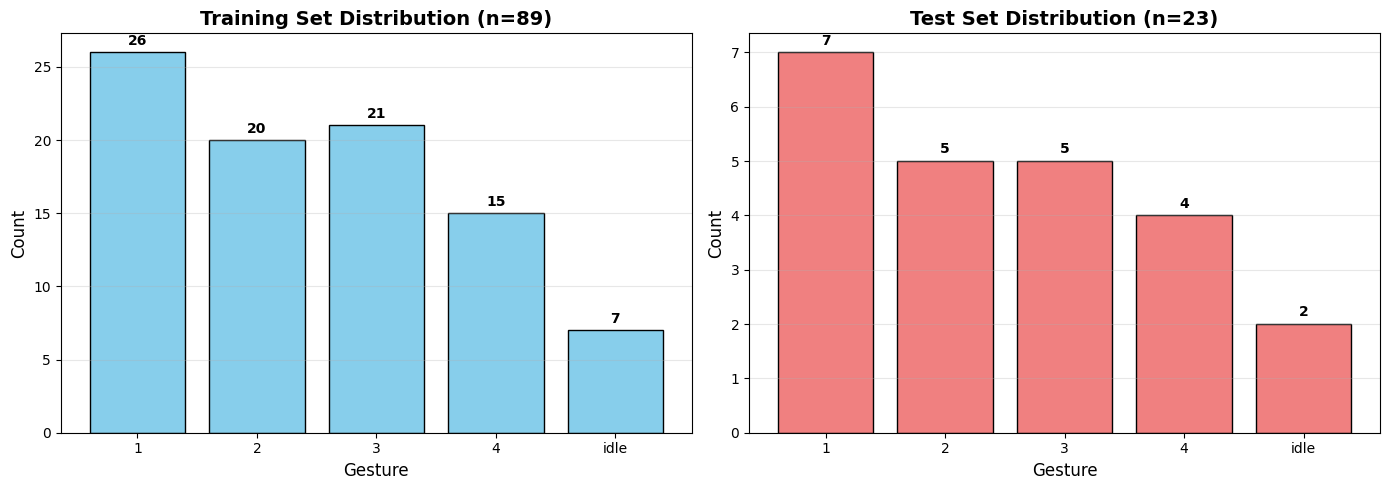


✓ Train-test split completed


In [34]:
# Train-Test Split

print("\n" + "="*50)
print("STEP 7: TRAIN-TEST SPLIT")
print("="*50)

# Prepare data
X = X_final.values
y = y_encoded

# Split with stratification
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

print(f"Split configuration:")
print(f"  Test size: {test_size*100:.0f}%")
print(f"  Random state: {random_state}")
print(f"  Stratification: Yes")

print(f"\nDataset sizes:")
print(f"  Total samples: {len(X)}")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Check stratification
print(f"\nTraining set class distribution:")
for class_idx in range(len(le.classes_)):
    count = np.sum(y_train == class_idx)
    print(f"  {le.classes_[class_idx]}: {count} ({count/len(y_train)*100:.2f}%)")

print(f"\nTest set class distribution:")
for class_idx in range(len(le.classes_)):
    count = np.sum(y_test == class_idx)
    print(f"  {le.classes_[class_idx]}: {count} ({count/len(y_test)*100:.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
train_counts = [np.sum(y_train == i) for i in range(len(le.classes_))]
axes[0].bar(le.classes_, train_counts, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Gesture', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title(f'Training Set Distribution (n={len(y_train)})', 
                 fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(train_counts):
    axes[0].text(i, v + max(train_counts)*0.02, str(v), ha='center', fontweight='bold')

# Test distribution
test_counts = [np.sum(y_test == i) for i in range(len(le.classes_))]
axes[1].bar(le.classes_, test_counts, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Gesture', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title(f'Test Set Distribution (n={len(y_test)})', 
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(test_counts):
    axes[1].text(i, v + max(test_counts)*0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('./data/output/train_test_split.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: ./data/output/train_test_split.png")
plt.show()

print("\n✓ Train-test split completed")


STEP 8: FEATURE SCALING
Scaling method: StandardScaler (mean=0, std=1)

Fitting scaler on training data...
✓ Training set scaled
✓ Test set scaled

Scaling statistics:
  Mean of scaled training features: 0.000000
  Std of scaled training features: 1.000000
  Mean of scaled test features: 0.039403
  Std of scaled test features: 0.937407

✓ Saved: ./data/output/feature_scaling.png


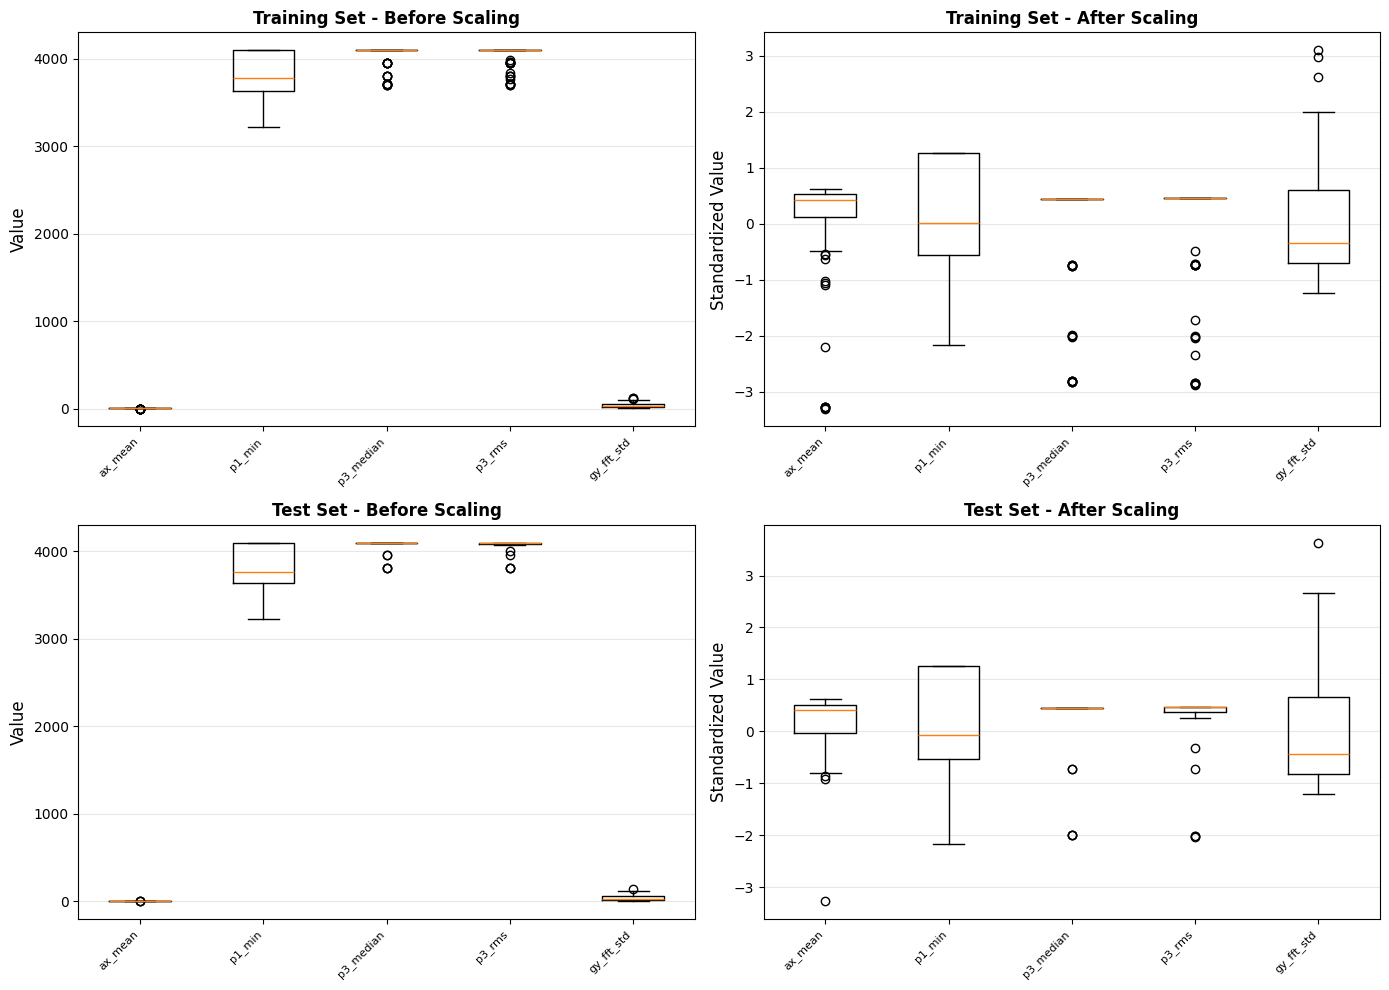


✓ Feature scaling completed


In [35]:
# Feature Scaling

print("\n" + "="*50)
print("STEP 8: FEATURE SCALING")
print("="*50)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
print("Scaling method: StandardScaler (mean=0, std=1)")
print("\nFitting scaler on training data...")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Training set scaled")
print("✓ Test set scaled")

# Show scaling statistics
print("\nScaling statistics:")
print(f"  Mean of scaled training features: {X_train_scaled.mean():.6f}")
print(f"  Std of scaled training features: {X_train_scaled.std():.6f}")
print(f"  Mean of scaled test features: {X_test_scaled.mean():.6f}")
print(f"  Std of scaled test features: {X_test_scaled.std():.6f}")

# Visualization - before and after scaling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Before scaling - training
sample_features_indices = [0, 10, 20, 30, 40]  # sample features
axes[0, 0].boxplot([X_train[:, i] for i in sample_features_indices])
axes[0, 0].set_xticklabels([selected_features[i][:15] for i in sample_features_indices], 
                           rotation=45, ha='right', fontsize=8)
axes[0, 0].set_ylabel('Value', fontsize=12)
axes[0, 0].set_title('Training Set - Before Scaling', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# After scaling - training
axes[0, 1].boxplot([X_train_scaled[:, i] for i in sample_features_indices])
axes[0, 1].set_xticklabels([selected_features[i][:15] for i in sample_features_indices], 
                           rotation=45, ha='right', fontsize=8)
axes[0, 1].set_ylabel('Standardized Value', fontsize=12)
axes[0, 1].set_title('Training Set - After Scaling', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Before scaling - test
axes[1, 0].boxplot([X_test[:, i] for i in sample_features_indices])
axes[1, 0].set_xticklabels([selected_features[i][:15] for i in sample_features_indices], 
                           rotation=45, ha='right', fontsize=8)
axes[1, 0].set_ylabel('Value', fontsize=12)
axes[1, 0].set_title('Test Set - Before Scaling', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# After scaling - test
axes[1, 1].boxplot([X_test_scaled[:, i] for i in sample_features_indices])
axes[1, 1].set_xticklabels([selected_features[i][:15] for i in sample_features_indices], 
                           rotation=45, ha='right', fontsize=8)
axes[1, 1].set_ylabel('Standardized Value', fontsize=12)
axes[1, 1].set_title('Test Set - After Scaling', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./data/output/feature_scaling.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: ./data/output/feature_scaling.png")
plt.show()

print("\n✓ Feature scaling completed")

In [36]:
# Model Training

print("\n" + "="*50)
print("STEP 9: MODEL TRAINING")
print("="*50)

# Define models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50,
        max_depth=2,
        learning_rate=0.05,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        random_state=42,
        probability=True
    )
}

print(f"Training {len(models)} models:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")

results = {}
best_accuracy = 0
best_model_name = None

# Train each model
for name, model in models.items():
    print("\n" + "="*50)
    print(f"Training: {name}")
    print("="*50)
    
    # Cross-validation
    print("Performing 5-fold cross-validation...")
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"CV Scores: {cv_scores}")
    print(f"CV Mean: {cv_scores.mean():.4f}")
    print(f"CV Std: {cv_scores.std():.4f}")
    
    # Train on full training set
    print(f"\nTraining on full training set ({len(X_train)} samples)...")
    model.fit(X_train_scaled, y_train)
    print("✓ Training completed")
    
    # Predictions
    print("Making predictions...")
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Evaluate
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"\nResults:")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Check overfitting
    overfit_diff = train_accuracy - test_accuracy
    if overfit_diff > 0.1:
        print(f"  ⚠ Possible overfitting (diff: {overfit_diff:.4f})")
    else:
        print(f"  ✓ Good generalization (diff: {overfit_diff:.4f})")
    
    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred
    }
    
    # Track best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_name = name
        best_model = results[best_model_name]['model']
    
    # Classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print("\nModel Comparison:")
print(f"{'Model':<20} {'Train Acc':<12} {'Test Acc':<12} {'CV Acc':<15} {'Overfit':<10}")
print("-" * 75)
for name, res in results.items():
    overfit = res['train_accuracy'] - res['test_accuracy']
    print(f"{name:<20} {res['train_accuracy']:<12.4f} {res['test_accuracy']:<12.4f} "
          f"{res['cv_mean']:.4f}±{res['cv_std']:.4f}   {overfit:>7.4f}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f}")

print("\n✓ Model training completed")


STEP 9: MODEL TRAINING
Training 3 models:
  1. Random Forest
  2. Gradient Boosting
  3. SVM

Training: Random Forest
Performing 5-fold cross-validation...
CV Scores: [0.94444444 1.         0.94444444 0.88888889 0.94117647]
CV Mean: 0.9438
CV Std: 0.0352

Training on full training set (89 samples)...
✓ Training completed
Making predictions...

Results:
  Training Accuracy: 0.9888
  Test Accuracy: 0.9565
  CV Accuracy: 0.9438 (±0.0352)
  ✓ Good generalization (diff: 0.0322)

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
        idle       1.00      0.50      0.67         2

    accuracy                           0.96        23
   macro avg       0.97      0.90      0.92        23
weighted avg       0.96      0.96      0.95        2


STEP 11: FEATURE IMPORTANCE ANALYSIS
Analyzing feature importance for Random Forest...

Top 20 Most Important Features:
Rank   Feature                                  Importance  
------------------------------------------------------------
1      p_active_sensors_mean                    0.110746    
2      p_diff_01                                0.070594    
3      p2_max                                   0.053896    
4      p1_rms                                   0.053485    
5      p1_energy                                0.047441    
6      p1_mean                                  0.042130    
7      p3_max                                   0.041710    
8      p_total_mean                             0.038973    
9      p2_mean                                  0.036255    
10     p_diff_12                                0.033250    
11     p2_energy                                0.032857    
12     p1_max                                   0.029584    
13     p_diff_23         

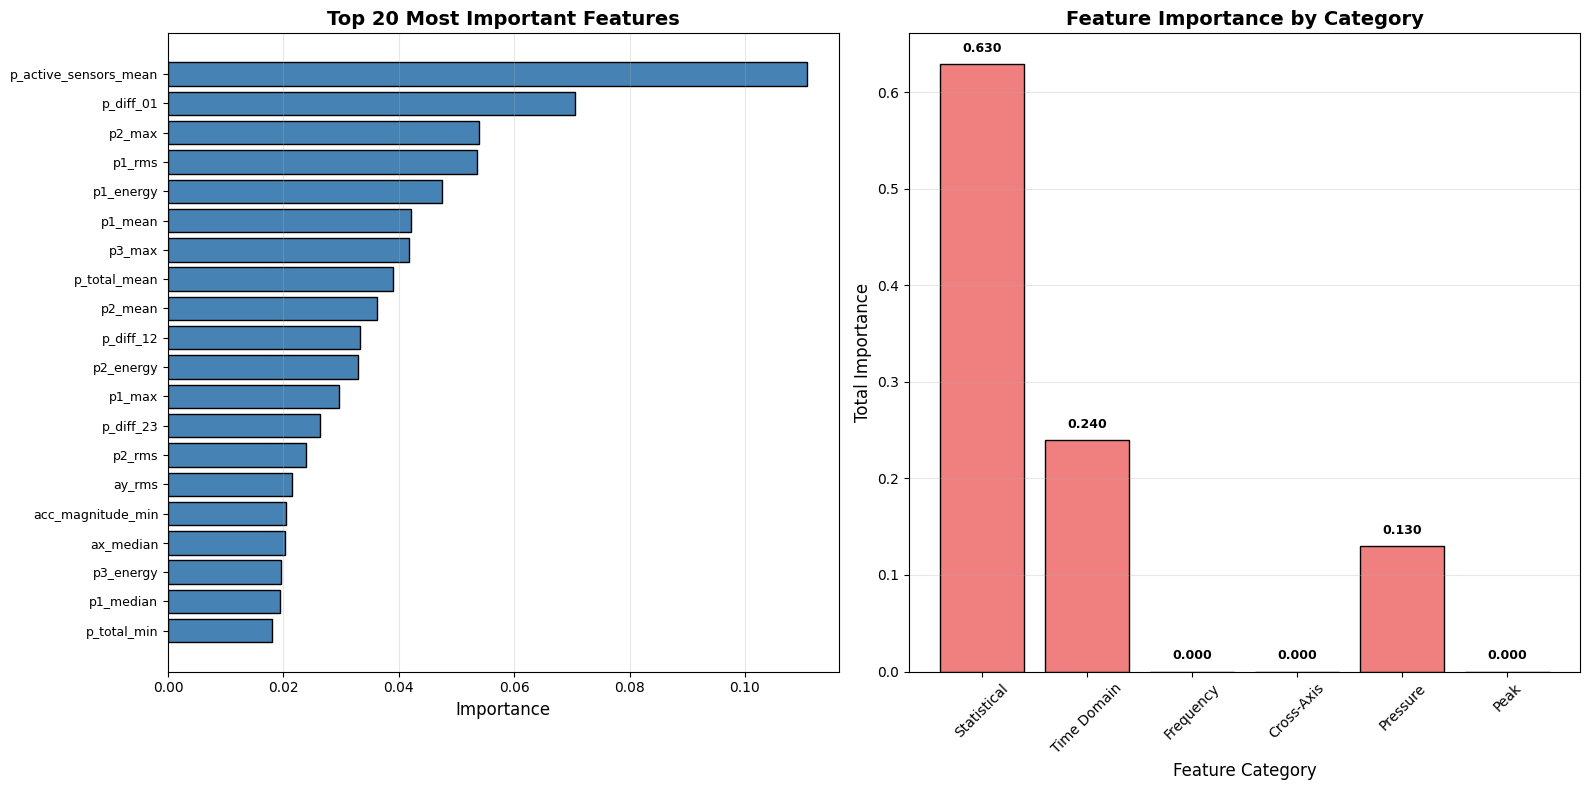

✓ Saved: ./data/output/feature_importance.csv

✓ Feature importance analysis completed


In [37]:
# Feature Importance

print("\n" + "="*50)
print("STEP 11: FEATURE IMPORTANCE ANALYSIS")
print("="*50)

if hasattr(best_model, 'feature_importances_'):
    print(f"Analyzing feature importance for {best_model_name}...")
    
    # Get feature importances
    feature_imp = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(f"{'Rank':<6} {'Feature':<40} {'Importance':<12}")
    print("-" * 60)
    for i, (_, row) in enumerate(feature_imp.head(20).iterrows(), 1):
        print(f"{i:<6} {row['feature']:<40} {row['importance']:<12.6f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 20 features
    top_20 = feature_imp.head(20)
    axes[0].barh(range(len(top_20)), top_20['importance'], color='steelblue', edgecolor='black')
    axes[0].set_yticks(range(len(top_20)))
    axes[0].set_yticklabels(top_20['feature'], fontsize=9)
    axes[0].set_xlabel('Importance', fontsize=12)
    axes[0].set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Feature importance by category
    categories = {
        'Statistical': 0,
        'Time Domain': 0,
        'Frequency': 0,
        'Cross-Axis': 0,
        'Pressure': 0,
        'Peak': 0
    }
    
    for _, row in feature_imp.iterrows():
        feat = row['feature']
        imp = row['importance']
        
        if any(x in feat for x in ['_mean', '_std', '_min', '_max', '_range', '_median']):
            categories['Statistical'] += imp
        elif any(x in feat for x in ['_rms', '_energy', '_zcr', '_skew', '_kurtosis']):
            categories['Time Domain'] += imp
        elif 'fft' in feat or 'freq' in feat:
            categories['Frequency'] += imp
        elif 'magnitude' in feat or 'jerk' in feat or 'corr' in feat:
            categories['Cross-Axis'] += imp
        elif feat.startswith('p_'):
            categories['Pressure'] += imp
        elif 'peak' in feat:
            categories['Peak'] += imp
    
    axes[1].bar(categories.keys(), categories.values(), color='lightcoral', edgecolor='black')
    axes[1].set_xlabel('Feature Category', fontsize=12)
    axes[1].set_ylabel('Total Importance', fontsize=12)
    axes[1].set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for i, (cat, val) in enumerate(categories.items()):
        axes[1].text(i, val + max(categories.values())*0.02, f'{val:.3f}', 
                    ha='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('./data/output/feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: ./data/output/feature_importance.png")
    plt.show()
    
    # Save feature importance to file
    feature_imp.to_csv('./data/output/feature_importance.csv', index=False)
    print("✓ Saved: ./data/output/feature_importance.csv")
    
else:
    print(f"⚠ {best_model_name} does not support feature_importances_")
    print("  Skipping feature importance analysis")

print("\n✓ Feature importance analysis completed")

In [38]:
# Save Final Model

print("\n" + "="*50)
print("STEP 12: SAVING TRAINED MODEL")
print("="*50)

# Create model package
model_package = {
    'model': best_model,
    'scaler': scaler,
    'label_encoder': le,
    'feature_names': selected_features,
    'model_name': best_model_name,
    'test_accuracy': best_accuracy,
    'train_accuracy': results[best_model_name]['train_accuracy'],
    'cv_mean': results[best_model_name]['cv_mean'],
    'cv_std': results[best_model_name]['cv_std'],
    'window_size': window_size,
    'step_size': step_size,
    'sensor_cols': sensor_cols,
    'num_features': len(selected_features),
    'num_classes': len(le.classes_),
    'classes': le.classes_.tolist()
}

# Save model
dump(model_package, './models/gesture_model.joblib')
print("✓ Saved: ./models/gesture_model.joblib")

print("\nModel package contents:")
print(f"  - Trained model: {best_model_name}")
print(f"  - Feature scaler: StandardScaler")
print(f"  - Label encoder: LabelEncoder")
print(f"  - Number of features: {len(selected_features)}")
print(f"  - Number of classes: {len(le.classes_)}")
print(f"  - Classes: {le.classes_.tolist()}")
print(f"  - Window configuration: size={window_size}, step={step_size}")

# Create model info file
with open('./data/output/model_info.txt', 'w', encoding="utf-8") as f:
    f.write("GESTURE RECOGNITION MODEL\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Model Type: {best_model_name}\n")
    f.write(f"Training Date: {pd.Timestamp.now()}\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 50 + "\n")
    f.write(f"Test Accuracy: {best_accuracy:.4f}\n")
    f.write(f"Training Accuracy: {results[best_model_name]['train_accuracy']:.4f}\n")
    f.write(f"CV Accuracy: {results[best_model_name]['cv_mean']:.4f} (±{results[best_model_name]['cv_std']:.4f})\n\n")
    
    f.write("DATA CONFIGURATION:\n")
    f.write("-" * 50 + "\n")
    f.write(f"Window Size: {window_size} samples\n")
    f.write(f"Step Size: {step_size} samples\n")
    f.write(f"Number of Features: {len(selected_features)}\n")
    f.write(f"Number of Classes: {len(le.classes_)}\n")
    f.write(f"Classes: {', '.join(le.classes_)}\n\n")
    
    f.write("TRAINING DATA:\n")
    f.write("-" * 50 + "\n")
    f.write(f"Total Windows: {len(X_windows)}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Test Samples: {len(X_test)}\n\n")
    
    f.write("SELECTED FEATURES:\n")
    f.write("-" * 50 + "\n")
    for i, feat in enumerate(selected_features, 1):
        f.write(f"{i}. {feat}\n")

print("✓ Saved: ./data/output/model_info.txt")

print("\n✓ Model saving completed")


STEP 12: SAVING TRAINED MODEL
✓ Saved: ./models/gesture_model.joblib

Model package contents:
  - Trained model: Random Forest
  - Feature scaler: StandardScaler
  - Label encoder: LabelEncoder
  - Number of features: 50
  - Number of classes: 5
  - Classes: ['1', '2', '3', '4', 'idle']
  - Window configuration: size=41, step=20
✓ Saved: ./data/output/model_info.txt

✓ Model saving completed


In [39]:
# Final Summary และ Example Usage

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)

print("\n📊 DATASET:")
print(f"  Original rows: {len(df)}")
print(f"  Total windows: {len(X_windows)}")
print(f"  Features extracted: {X_features.shape[1]}")
print(f"  Features selected: {len(selected_features)}")
print(f"  Classes: {', '.join(le.classes_)}")

print("\n🔧 PREPROCESSING:")
print(f"  Window size: {window_size} samples")
print(f"  Step size: {step_size} samples")
print(f"  Overlap: {((window_size - step_size) / window_size * 100):.0f}%")
print(f"  Feature selection: Top {len(selected_features)} features")
print(f"  Scaling: StandardScaler")

print("\n🤖 MODELS TRAINED:")
for i, (name, res) in enumerate(results.items(), 1):
    print(f"  {i}. {name}: {res['test_accuracy']:.4f}")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"  Test Accuracy: {best_accuracy:.4f}")
print(f"  Training Accuracy: {results[best_model_name]['train_accuracy']:.4f}")
print(f"  CV Accuracy: {results[best_model_name]['cv_mean']:.4f} (±{results[best_model_name]['cv_std']:.4f})")

print("\n📁 FILES SAVED:")
saved_files = [
    'gesture_data_cleaned.csv',
    'features_processed.csv',
    'selected_features.txt',
    'label_encoder.joblib',
    'gesture_model.joblib',
    'model_info.txt',
    'data_distribution.png',
    'sample_timeseries.png',
    'gesture_distribution.png',
    'windowing_results.png',
    'feature_selection.png',
    'train_test_split.png',
    'feature_scaling.png',
    'confusion_matrix.png',
    'model_evaluation.png'
]

if hasattr(best_model, 'feature_importances_'):
    saved_files.extend(['feature_importance.png', 'feature_importance.csv'])

for i, file in enumerate(saved_files, 1):
    print(f"  {i}. {file}")

print("\n" + "="*50)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("="*50)

# Example usage code
print("\n" + "="*50)
print("EXAMPLE USAGE")
print("="*50)

example_code = '''
# Load the trained model
from joblib import load
import numpy as np
import pandas as pd

# Load model package
model_package = load('gesture_model.joblib')
model = model_package['model']
scaler = model_package['scaler']
le = model_package['label_encoder']
feature_names = model_package['feature_names']
sensor_cols = model_package['sensor_cols']

print(f"Model: {model_package['model_name']}")
print(f"Accuracy: {model_package['test_accuracy']:.4f}")
print(f"Classes: {model_package['classes']}")

# Function to predict gesture from new window
def predict_gesture(new_window_data):
    """
    new_window_data: numpy array shape (100, 10)
                     columns: [ax, ay, az, gx, gy, gz, p0, p1, p2, p3]
    """
    # Extract features using the same functions
    features = extract_all_features(new_window_data, sensor_cols)
    features_df = pd.DataFrame([features])
    
    # Select only trained features
    features_df = features_df[feature_names]
    
    # Scale
    features_scaled = scaler.transform(features_df)
    
    # Predict
    prediction = model.predict(features_scaled)
    probabilities = model.predict_proba(features_scaled)
    
    # Decode
    gesture_name = le.inverse_transform(prediction)[0]
    confidence = probabilities.max()
    
    return gesture_name, confidence, probabilities[0]

# Example: Predict on new data
# new_data = your_sensor_data  # shape (100, 10)
# gesture, conf, probs = predict_gesture(new_data)
# print(f"Predicted: {gesture} (confidence: {conf:.2%})")
# print(f"Probabilities: {dict(zip(le.classes_, probs))}")
'''

print(example_code)

print("\n✅ All done! Your gesture recognition model is ready to use.")


FINAL SUMMARY

📊 DATASET:
  Original rows: 2361
  Total windows: 112
  Features extracted: 173
  Features selected: 50
  Classes: 1, 2, 3, 4, idle

🔧 PREPROCESSING:
  Window size: 41 samples
  Step size: 20 samples
  Overlap: 51%
  Feature selection: Top 50 features
  Scaling: StandardScaler

🤖 MODELS TRAINED:
  1. Random Forest: 0.9565
  2. Gradient Boosting: 0.9130
  3. SVM: 0.9130

🏆 BEST MODEL: Random Forest
  Test Accuracy: 0.9565
  Training Accuracy: 0.9888
  CV Accuracy: 0.9438 (±0.0352)

📁 FILES SAVED:
  1. gesture_data_cleaned.csv
  2. features_processed.csv
  3. selected_features.txt
  4. label_encoder.joblib
  5. gesture_model.joblib
  6. model_info.txt
  7. data_distribution.png
  8. sample_timeseries.png
  9. gesture_distribution.png
  10. windowing_results.png
  11. feature_selection.png
  12. train_test_split.png
  13. feature_scaling.png
  14. confusion_matrix.png
  15. model_evaluation.png
  16. feature_importance.png
  17. feature_importance.csv

✅ PIPELINE COMPLETED